In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle
import numpy as np

In [42]:
df = pd.read_csv("model_avgs.csv")

In [43]:
df.rename( columns={'Unnamed: 0':'Model_Type'}, inplace=True )
df["Model_Type"] = df["Model_Type"].str.replace("Model", "").str.strip()

In [44]:
# Add Avg ST Cons to dataset
avg_st_cons = []

for model in df["Model_Type"]:
    with open(f'pkls/tree_const_m{model}.pkl', 'rb') as f:
        tree_const = pickle.load(f)
    avg_st_cons.append(np.mean(tree_const).round(2))

df["avg_st_con"] = avg_st_cons

In [50]:
model_colors = {
    "2": "tab:green",
    "3": "cornflowerblue",
    "4": "indigo",
    "4b": "tab:purple",
    "5": "deeppink",
    "5b": "tab:pink",
    "6": "tab:orange",
    "7": "brown",
    "8": "tab:cyan",
    "9": "lightcoral",
    "9b": "indianred",
    "10": "tab:olive",
    "10b": "gold",
    "11": "springgreen",
    "11b": "forestgreen",
    "11c": "yellowgreen"
}
colors = df["Model_Type"].map(model_colors)

In [46]:
# Real Data
rd_avg_deg = 5.4
with open(f'pkls/tree_const_real.pkl', 'rb') as f:
        tree_const = pickle.load(f)
        rd_st_cons = np.mean(tree_const)

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_90448/3373584458.py:4: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(f'Real Data', (rd_st_cons, rd_avg_deg), textcoords="offset pixels")


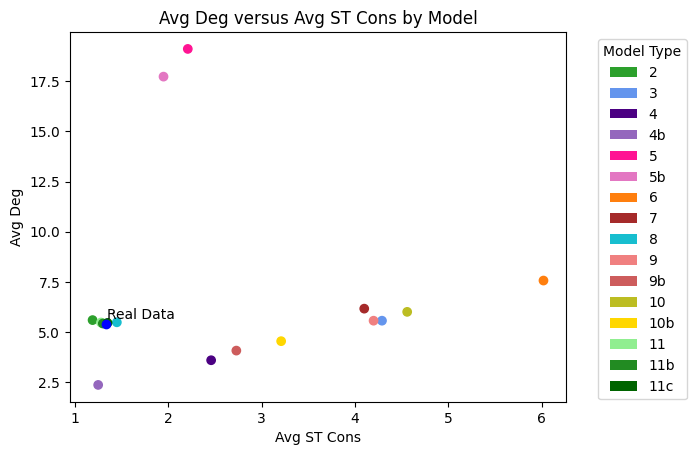

In [52]:
plt.scatter(x=df["avg_st_con"], y=df["avg_deg"], c=colors)

plt.scatter(x=rd_st_cons, y=rd_avg_deg, c="blue")
plt.annotate(f'Real Data', (rd_st_cons, rd_avg_deg), textcoords="offset pixels")

plt.xlabel("Avg ST Cons")
plt.ylabel("Avg Deg")
legend_elements = [Patch(facecolor=color, label=label) for label, color in model_colors.items()]
plt.legend(handles=legend_elements, title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Avg Deg versus Avg ST Cons by Model")
plt.savefig(f'imgs/av_deg_st_cons_by_model.png')

In [53]:
df

,Model_Type,planar,connected,avg_deg,median_deg,max_deg,avg_st_con
0,2,0.00,1.0,5.60,5.41,11.18,1.19
1,3,1.00,0.9,5.57,5.56,9.66,4.29
2,4,1.00,1.0,3.60,3.64,7.49,2.46
3,4b,1.00,1.0,2.37,2.13,5.63,1.25
4,5,0.00,1.0,19.11,19.00,29.71,2.21
5,5b,0.07,1.0,17.73,17.60,28.03,1.95
6,6,0.00,1.0,7.57,7.50,13.08,6.02
7,7,0.00,1.0,6.17,5.93,12.29,4.10
8,8,0.00,1.0,5.49,5.40,10.16,1.45
9,9,0.00,1.0,5.57,5.53,10.17,4.20
